In [24]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [25]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [26]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

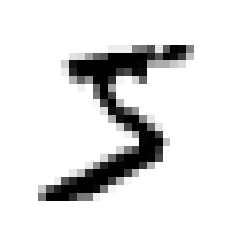

In [45]:
# reshaping the 784 pixels in X into a 28x28 grid
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [30]:
# label for 'some_digit'
y[0]

'5'

In [31]:
# converting label's string format to integer
import numpy as np
y = y.astype(np.uint8)
y[0]

5

In [32]:
# train/test split (MNIST is split to 60,000/10,000 train/test already)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [46]:
# training binary classifier for just "5" and "not 5"

y_train_5 = (y_train == 5) # true for all 5, false for not
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit]) # some_digit represents a hand-written five

array([ True])

In [51]:
# implementing cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [52]:
# cross-validation using built-in function
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [54]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

By always guessing that the number is not a 5, you still end up with about a 90% of accuracy because only about 10% of the dataset consists of actual fives. Because of this, accuracy is generally not the best performance measure for classification models.

In [55]:
# confusion matrix to measure performance
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [56]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

top left: true negatives, top right: false negatives, bottom left: false positives, bottom right: true positives

In [57]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

$precision = \frac{TP}{TP + FP}$

Represents the accuracy of the positive predictions, where TP is the true positives, and FP is the false positives.

$recall = \frac{TP}{TP + FN}$

Also known as the "sensitivty" or "true positive rate", where FN is the false negatives.

In [58]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


To combine precision and recall into a single score, we can use the F1 score:

$ F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2*\frac{precision*recall}{precision+recall}=\frac{TP}{TP+\frac{FN+FP}{2}} $

In [59]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [60]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [62]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [63]:
# but what if we up the threshold?
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [64]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [66]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

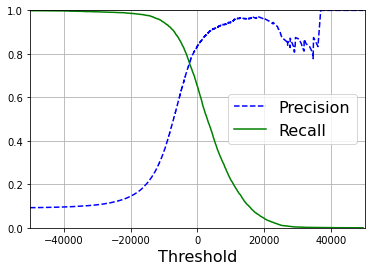

In [69]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [70]:
# threshold that makes it 90% precise
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [71]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print('precision:', precision_score(y_train_5, y_train_pred_90))
print('recall:', recall_score(y_train_5, y_train_pred_90))

precision: 0.9000345901072293
recall: 0.4799852425751706


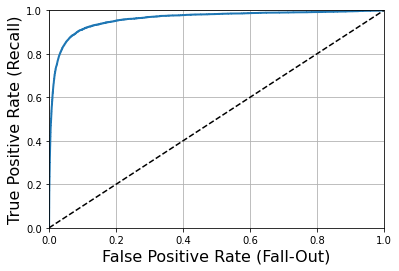

In [72]:
# receiver operating characteristic (ROC)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()